In [235]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
from scipy.stats import beta

In [236]:
num_trials = 20000
eps = 0.1
bandit_rewards = [1,2,3,4]

### Bandit Class

In [237]:
from abc import ABC, abstractmethod
from loguru import logger

class Bandit(ABC):

    @abstractmethod
    def __init__(self, p):
        pass

    @abstractmethod
    def __repr__(self):
        pass

    @abstractmethod
    def pull(self):
        pass

    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def experiment(self):
        pass

    @abstractmethod
    def report(self):
        # store data in csv
        # print average reward (use f strings to make it informative)
        # print average regret (use f strings to make it informative)
        pass


def comparison():
    # think of a way to compare the performances of the two algorithms VISUALLY and 
    pass

if __name__=='__main__':
   
    logger.debug("debug message")
    logger.info("info message")
    logger.warning("warning message")
    logger.error("error message")
    logger.critical("critical message")

2025-03-28 23:24:01.779 | DEBUG    | __main__:<module>:40 - debug message
2025-03-28 23:24:01.780 | INFO     | __main__:<module>:41 - info message
2025-03-28 23:24:01.781 | WARNING  | __main__:<module>:42 - warning message
2025-03-28 23:24:01.782 | ERROR    | __main__:<module>:43 - error message
2025-03-28 23:24:01.782 | CRITICAL | __main__:<module>:44 - critical message


### Epsilon Greedy Algorithm

In [238]:

class EpsilonGreedy(Bandit):
    def __init__(self, p):
        self.p = p  # True probability of success
        self.p_estimate = 0  # Estimated probability
        self.N = 0  # Number of pulls
    
    def __repr__(self):
        return f'Bandit with {self.p:.2f} Win Rate'
    
    def pull(self):
        """Simulate pulling the bandit arm and returning a reward of 1 or 0."""
        return 1 if np.random.rand() < self.p else 0
    
    def update(self, reward):
        """Update estimated probability using incremental mean formula."""
        self.N += 1
        self.p_estimate = ((self.N - 1) * self.p_estimate + reward) / self.N
    
    def experiment(self, bandit_probs, num_trials):
        """Run Epsilon-Greedy experiment for a given number of trials."""
        bandits = [EpsilonGreedy(p) for p in bandit_probs]
        t = 1
        eps = 1 / t  # Initial epsilon
        rewards = []
        bandit_selections = []
        true_best = np.argmax(bandit_probs)
        count_suboptimal = 0

        for i in range(num_trials):
            if np.random.rand() < eps:  
                j = np.random.choice(len(bandits))  # Exploration
            else:
                j = np.argmax([b.p_estimate for b in bandits])  # Exploitation
            
            reward = bandits[j].pull()
            bandits[j].update(reward)

            rewards.append(reward)
            bandit_selections.append(j)
            
            if j != true_best:
                count_suboptimal += 1

            t += 1
            eps = 1 / t  # Decay epsilon

        # Compute cumulative average reward
        cumulative_average = np.cumsum(rewards) / (np.arange(num_trials) + 1)

        # Store results in CSV
        df = pd.DataFrame({
            "Bandit": bandit_selections,
            "Reward": rewards,
            "Algorithm": "EpsilonGreedy"
        })
        df.to_csv("epsilon_greedy_results.csv", index=False)

        return rewards, bandit_selections, cumulative_average, count_suboptimal
    
    def report(self, bandit_probs, num_trials, rewards):
        """Generate and plot the regret of the algorithm."""
        best_reward = max(bandit_probs)
        optimal_total_reward = np.full(num_trials, best_reward).cumsum()
        regret = optimal_total_reward - np.cumsum(rewards)
        
        # Print cumulative reward
        print(f"Cumulative Reward (Epsilon Greedy): {np.cumsum(rewards)[-1]}")

        # Print cumulative regret
        print(f"Cumulative Regret (Epsilon Greedy): {regret[-1]}")
        
        # Visualization
        plt.figure(figsize=(10, 5))
        plt.plot(regret, label="Cumulative Regret", color="red")
        plt.xlabel("Trials")
        plt.ylabel("Regret")
        plt.title("Cumulative Regret - Epsilon Greedy")
        plt.legend()
        plt.show()


### Thompson Sampling

In [239]:
class ThompsonSampling(Bandit):
    def __init__(self, true_mean):
        self.true_mean = true_mean
        self.m = 0
        self.lambda_ = 1
        self.tau = 1
        self.N = 0
    
    def __repr__(self):
        return f'Bandit with {self.true_mean:.2f} Win Rate'

    def pull(self):
        return np.random.randn() / np.sqrt(self.tau) + self.true_mean
    
    def sample(self):
        return np.random.randn() / np.sqrt(self.lambda_) + self.m

    def update(self, reward):
        self.m = (self.tau * reward + self.lambda_ * self.m) / (self.tau + self.lambda_)
        self.lambda_ += self.tau
        self.N += 1
    
    def experiment(self, bandit_rewards, num_trials):
        """Run Thompson Sampling experiment for a given number of trials."""
        bandits = [ThompsonSampling(m) for m in bandit_rewards]
        rewards = []
        bandit_selections = []

        for i in range(num_trials):
            j = np.argmax([b.sample() for b in bandits])  # Select bandit with max sample

            reward = bandits[j].pull()
            bandits[j].update(reward)

            rewards.append(reward)
            bandit_selections.append(j)

        cumulative_average = np.cumsum(rewards) / (np.arange(num_trials) + 1)

        # Store results in CSV
        df = pd.DataFrame({
            "Bandit": bandit_selections,
            "Reward": rewards,
            "Algorithm": "ThompsonSampling"
        })
        df.to_csv("thompson_sampling_results.csv", index=False)

        return rewards, bandit_selections, cumulative_average
    
    def report(self, bandit_rewards, num_trials, rewards):
        """Generate and plot the regret of the algorithm."""
        best_reward = max(bandit_rewards)
        optimal_total_reward = np.full(num_trials, best_reward).cumsum()
        regret = optimal_total_reward - np.cumsum(rewards)
        
        # Print cumulative reward
        print(f"Cumulative Reward (Thompson Sampling): {np.cumsum(rewards)[-1]}")

        # Print cumulative regret
        print(f"Cumulative Regret (Thompson Sampling): {regret[-1]}")
        
        # Visualization
        plt.figure(figsize=(10, 5))
        plt.plot(regret, label="Cumulative Regret", color="blue")
        plt.xlabel("Trials")
        plt.ylabel("Regret")
        plt.title("Cumulative Regret - Thompson Sampling")
        plt.legend()
        plt.show()

In [240]:
# Run Epsilon Greedy experiment
eg = EpsilonGreedy(0)  # Dummy instance to call the methods
eg_rewards, eg_selections, eg_cumulative_avg, eg_suboptimal = eg.experiment(bandit_rewards, num_trials)

In [241]:
# Run Thompson Sampling experiment
ts = ThompsonSampling(0)  # Instantiate the ThompsonSampling object
ts_rewards, ts_selections, ts_cumulative_avg = ts.experiment(bandit_rewards, num_trials)

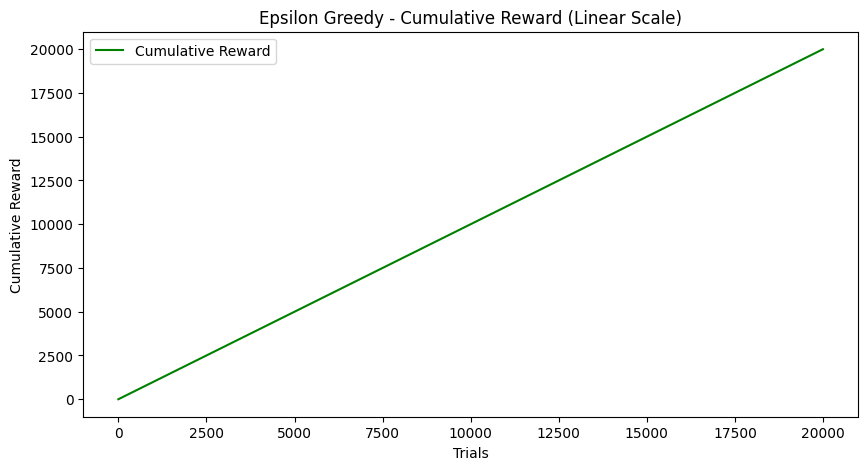

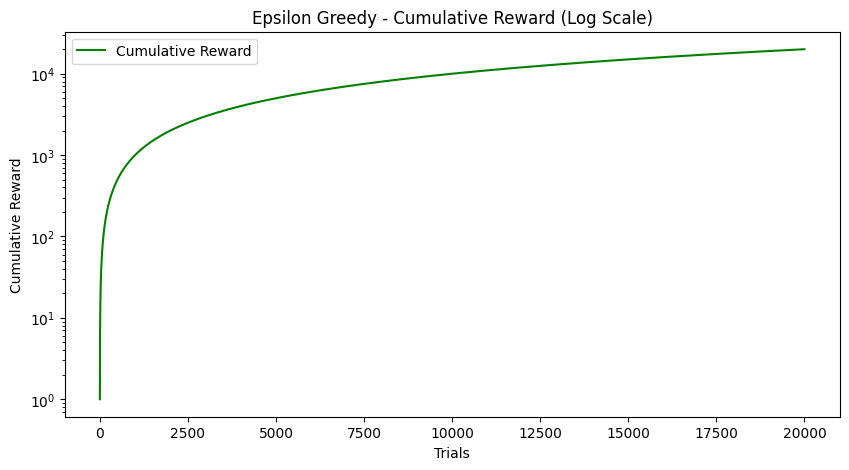

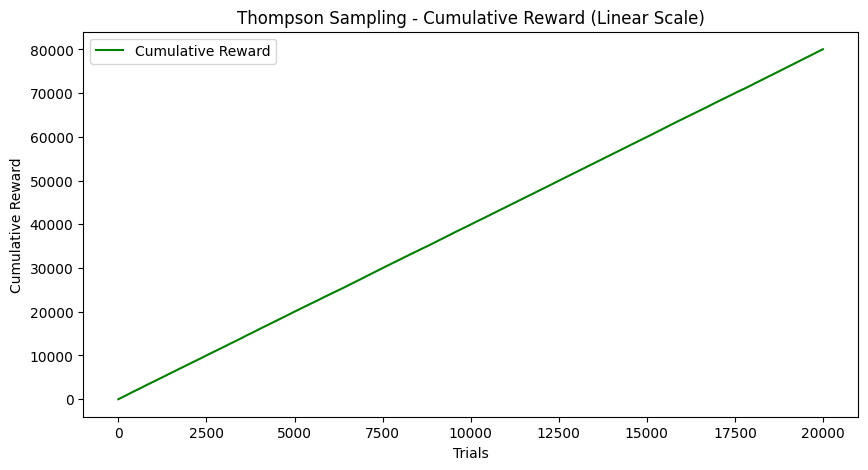

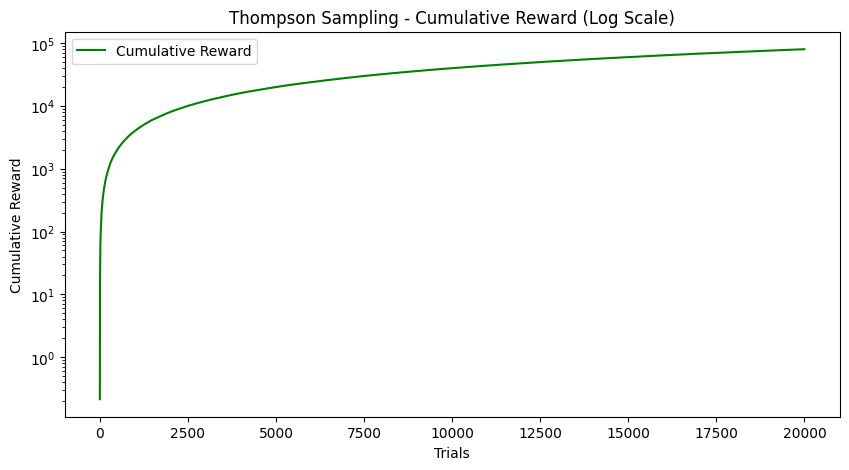

In [242]:
# Visualization
viz = Visualization()
viz.plot1(bandit_rewards, eg_rewards, eg_selections, "Epsilon Greedy")
viz.plot1(bandit_rewards, ts_rewards, ts_selections, "Thompson Sampling")


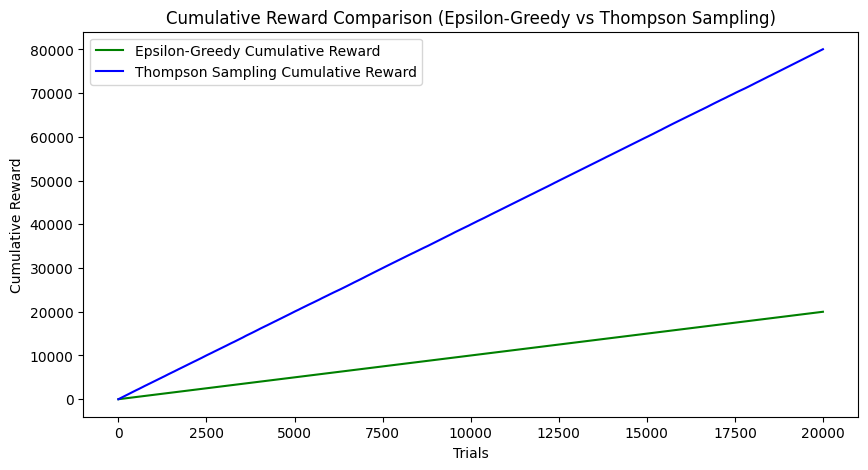

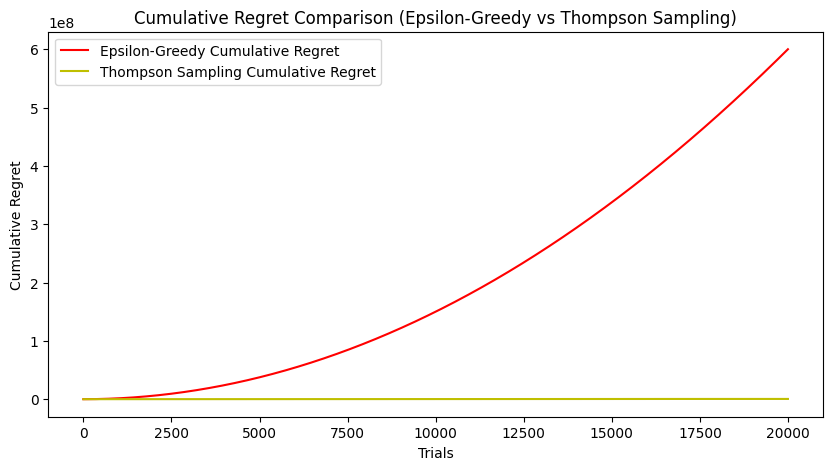

Cumulative Reward (Epsilon Greedy): 20000
Cumulative Regret (Epsilon Greedy): 60000


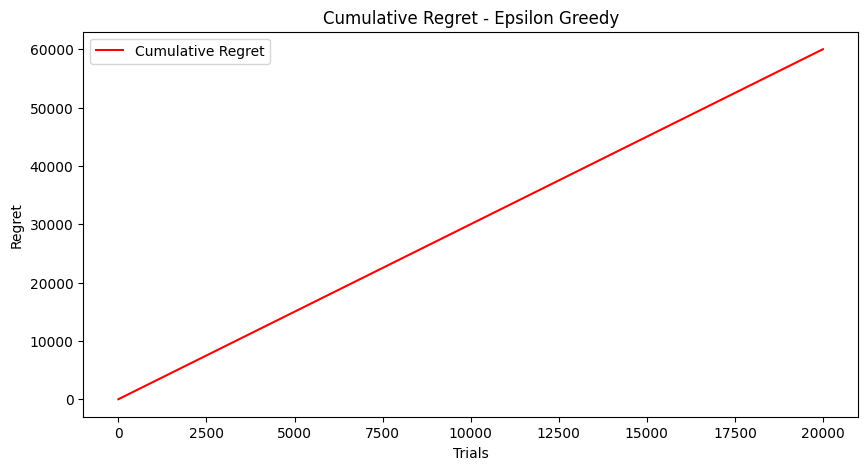

Cumulative Reward (Thompson Sampling): 80040.13327784918
Cumulative Regret (Thompson Sampling): -40.13327784917783


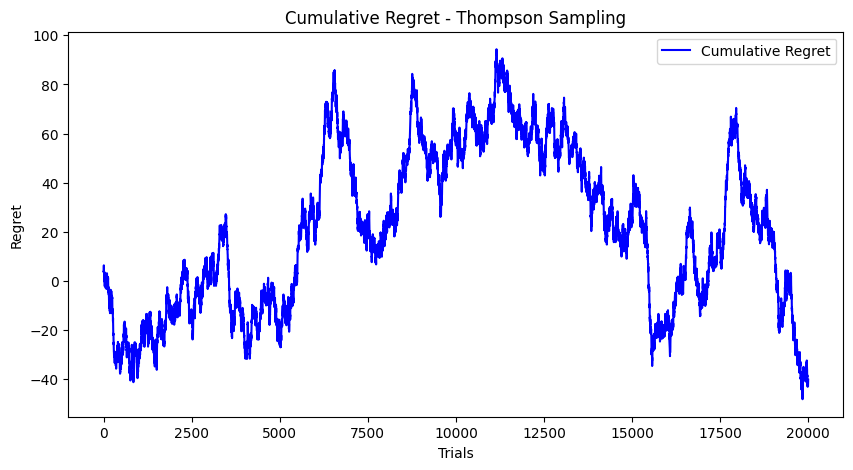

In [243]:
# Calculate regret and visualize comparison
eg_regret = np.cumsum(np.full_like(eg_rewards, max(bandit_rewards))) - np.cumsum(eg_rewards)
ts_regret = np.cumsum(np.full_like(ts_rewards, max(bandit_rewards))) - np.cumsum(ts_rewards)

viz.plot2(eg_rewards, ts_rewards, eg_regret, ts_regret)

# Report
eg.report(bandit_rewards, num_trials, eg_rewards)
ts.report(bandit_rewards, num_trials, ts_rewards)

In [244]:
# Epsilon-Greedy Results
eg_regret = np.cumsum(np.full_like(eg_rewards, max(bandit_rewards))) - np.cumsum(eg_rewards)
print(f"--- Epsilon-Greedy ---")
print(f"Cumulative Reward (Epsilon-Greedy): {np.cumsum(eg_rewards)[-1]}")
print(f"Cumulative Regret (Epsilon-Greedy): {eg_regret[-1]}")


# Thompson Sampling Results
ts_regret = np.cumsum(np.full_like(ts_rewards, max(bandit_rewards))) - np.cumsum(ts_rewards)
print(f"--- Thompson Sampling ---")
print(f"Cumulative Reward (Thompson Sampling): {np.cumsum(ts_rewards)[-1]}")
print(f"Cumulative Regret (Thompson Sampling): {ts_regret[-1]}")


--- Epsilon-Greedy ---
Cumulative Reward (Epsilon-Greedy): 20000
Cumulative Regret (Epsilon-Greedy): 60000
--- Thompson Sampling ---
Cumulative Reward (Thompson Sampling): 80040.13327784918
Cumulative Regret (Thompson Sampling): -40.13327784917783


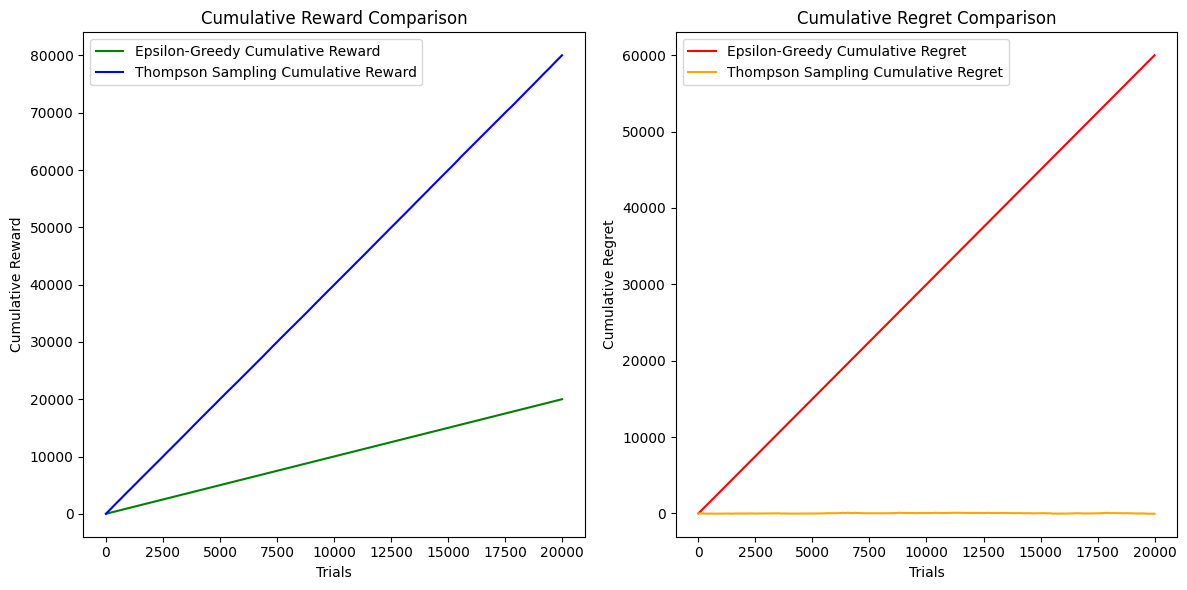

In [245]:
def comparison(eg_rewards, ts_rewards, bandit_rewards, num_trials):
    # Calculate cumulative reward for EpsilonGreedy (eg) and ThompsonSampling (ts)
    eg_cumulative_reward = np.cumsum(eg_rewards)
    ts_cumulative_reward = np.cumsum(ts_rewards)
    
    # Calculate cumulative regret for EpsilonGreedy (eg) and ThompsonSampling (ts)
    eg_regret = np.cumsum(np.full_like(eg_rewards, max(bandit_rewards))) - eg_cumulative_reward
    ts_regret = np.cumsum(np.full_like(ts_rewards, max(bandit_rewards))) - ts_cumulative_reward

    # Visualization
    plt.figure(figsize=(12, 6))

    # Compare cumulative rewards
    plt.subplot(1, 2, 1)
    plt.plot(eg_cumulative_reward, label="Epsilon-Greedy Cumulative Reward", color='green')
    plt.plot(ts_cumulative_reward, label="Thompson Sampling Cumulative Reward", color='blue')
    plt.xlabel("Trials")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Reward Comparison")
    plt.legend()

    # Compare cumulative regrets
    plt.subplot(1, 2, 2)
    plt.plot(eg_regret, label="Epsilon-Greedy Cumulative Regret", color='red')
    plt.plot(ts_regret, label="Thompson Sampling Cumulative Regret", color='orange')
    plt.xlabel("Trials")
    plt.ylabel("Cumulative Regret")
    plt.title("Cumulative Regret Comparison")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the comparison function after running experiments
comparison(eg_rewards, ts_rewards, bandit_rewards, num_trials)


### Better implementation of epsilon-greedy algorithm

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

class Bandit:
    """Base class for bandit algorithms."""
    def __init__(self, true_mean):
        self.true_mean = true_mean  # True probability of success
        self.N = 0  # Number of pulls
        self.rewards = []  # Reward history

    def pull(self):
        """Simulate pulling the bandit's arm."""
        return 1 if np.random.rand() < self.true_mean else 0

    def update(self, reward):
        """Update bandit statistics."""
        self.N += 1
        self.rewards.append(reward)

    def get_estimate(self):
        """Compute estimated reward probability."""
        return np.mean(self.rewards) if self.rewards else 0


The epsilon (eps = 1/t) decays too aggressively, causing early exploitation.

Instead of a fixed decay, we can use exponential decay or annealing schedule.

In [247]:
class EpsilonGreedy(Bandit):
    def __init__(self, true_mean, epsilon=1.0, decay=0.99):
        super().__init__(true_mean)
        self.epsilon = epsilon  # Initial exploration rate
        self.decay = decay  # Exponential decay factor

    def select_action(self, bandits, trial):
        """Selects an action using Epsilon-Greedy."""
        if np.random.rand() < self.epsilon:
            choice = np.random.choice(len(bandits))  # Explore
        else:
            choice = np.argmax([b.get_estimate() for b in bandits])  # Exploit
        
        self.epsilon = max(0.01, self.epsilon * self.decay)  # Exponential decay
        return choice


### Thompson Sampling with Beta Distribution


In [248]:
class ThompsonSampling(Bandit):
    def __init__(self, true_mean):
        super().__init__(true_mean)
        self.alpha = 1  # Prior success count
        self.beta = 1   # Prior failure count

    def select_action(self, bandits, trial):
        """Selects an action using Thompson Sampling."""
        sampled_means = [np.random.beta(b.alpha, b.beta) for b in bandits]
        return np.argmax(sampled_means)

    def update(self, reward):
        """Update Beta distribution parameters."""
        super().update(reward)
        self.alpha += reward
        self.beta += (1 - reward)


###  Experiment Class for Running Trials

In [249]:
class BanditExperiment:
    def __init__(self, bandit_class, bandit_probs, num_trials, **kwargs):
        self.bandits = [bandit_class(p, **kwargs) for p in bandit_probs]
        self.num_trials = num_trials
        self.rewards = []
        self.selections = []

    def run(self):
        """Run the experiment for a given bandit strategy."""
        for t in range(self.num_trials):
            chosen_arm = self.bandits[0].select_action(self.bandits, t)
            reward = self.bandits[chosen_arm].pull()
            self.bandits[chosen_arm].update(reward)

            self.rewards.append(reward)
            self.selections.append(chosen_arm)

        return self.rewards, self.selections


In [250]:
def compute_regret(rewards, bandit_rewards, num_trials):
    """Compute cumulative regret for an algorithm."""
    best_mean_reward = max(bandit_rewards)
    optimal_total_reward = np.full(num_trials, best_mean_reward).cumsum()
    actual_total_reward = np.cumsum(rewards)
    return optimal_total_reward - actual_total_reward


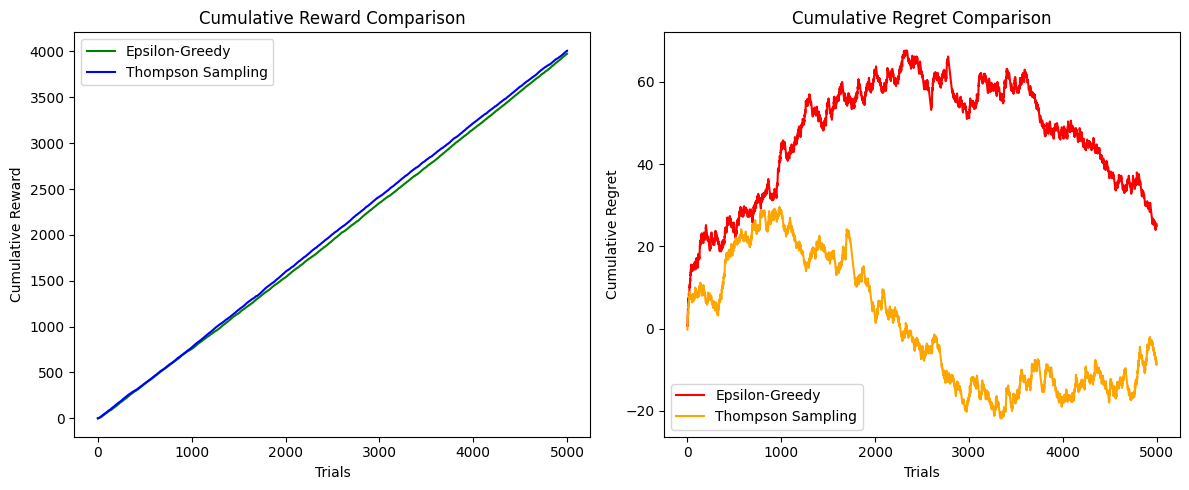

In [251]:
# Define bandit reward probabilities
bandit_rewards = [0.2, 0.4, 0.6, 0.8]
num_trials = 5000

# Run Epsilon-Greedy with Exponential Decay
eg_exp = BanditExperiment(EpsilonGreedy, bandit_rewards, num_trials, epsilon=1.0, decay=0.99)
eg_rewards, eg_selections = eg_exp.run()

# Run Thompson Sampling
ts_exp = BanditExperiment(ThompsonSampling, bandit_rewards, num_trials)
ts_rewards, ts_selections = ts_exp.run()

# Compute regrets
eg_regret = compute_regret(eg_rewards, bandit_rewards, num_trials)
ts_regret = compute_regret(ts_rewards, bandit_rewards, num_trials)

# Plot results
plt.figure(figsize=(12, 5))

# Cumulative Reward Plot
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(eg_rewards), label="Epsilon-Greedy", color="green")
plt.plot(np.cumsum(ts_rewards), label="Thompson Sampling", color="blue")
plt.xlabel("Trials")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward Comparison")
plt.legend()

# Cumulative Regret Plot
plt.subplot(1, 2, 2)
plt.plot(eg_regret, label="Epsilon-Greedy", color="red")
plt.plot(ts_regret, label="Thompson Sampling", color="orange")
plt.xlabel("Trials")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret Comparison")
plt.legend()

plt.tight_layout()
plt.show()
